<a href="https://colab.research.google.com/github/angzla/image-playlist-generator/blob/main/DataMiningFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

#make sure to change ram/disk to t4GPU before running

In [ ]:
# python image library of range [0, 1]
# transform them to tensors of normalized range[-1, 1]

transform = transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean = 0.5, std = 0.5

# set batch_size
batch_size = 4

# set number of workers
num_workers = 2

# load train data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

# load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

# put 10 classes into a set
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 77237671.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


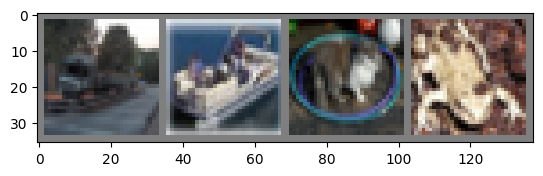

truck ship cat frog


In [ ]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(trainloader)
images, labels = next(dataiter)

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
class Net(nn.Module):
    ''' Models a simple Convolutional Neural Network'''
    def __init__(self):
      ''' initialize the network '''
      super(Net, self).__init__()
      # 3 input image channel, 6 output channels,
      # 5x5 square convolution kernel
      self.conv1 = nn.Conv2d(3, 6, 5)
      # Max pooling over a (2, 2) window
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(6, 16, 5)
      self.fc1 = nn.Linear(16 * 5 * 5, 120)# 5x5 from image dimension
      self.fc2 = nn.Linear(120, 84)
      self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
      ''' the forward propagation algorithm '''
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 16 * 5 * 5)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
#define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#train the network
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# whatever you are timing goes here
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))  # milliseconds

[1,  2000] loss: 2.247
[1,  4000] loss: 1.880
[1,  6000] loss: 1.684
[1,  8000] loss: 1.592
[1, 10000] loss: 1.522
[1, 12000] loss: 1.466
[2,  2000] loss: 1.388
[2,  4000] loss: 1.349
[2,  6000] loss: 1.352
[2,  8000] loss: 1.324
[2, 10000] loss: 1.294
[2, 12000] loss: 1.270
Finished Training
131883.125


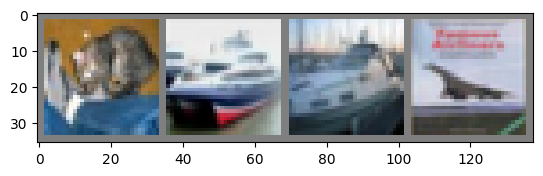

GroundTruth:  cat ship ship plane


In [ ]:
#testing model
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  cat ship plane ship


In [ ]:
#testing model on 1000 images
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


#Attempt 2: Tweaking features to increase accuracy

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
#from torchvision import transforms
from torchvision.utils import make_grid


import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#adding rotation transformation
class RandomRotation(object):
    """
    https://github.com/pytorch/vision/tree/master/torchvision/transforms
    Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img):
        """
            img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """

        def rotate(img, angle, resample=False, expand=False, center=None):
            """Rotate the image by angle and then (optionally) translate it by (n_columns, n_rows)
            Args:
            img (PIL Image): PIL Image to be rotated.
            angle ({float, int}): In degrees degrees counter clockwise order.
            resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
            expand (bool, optional): Optional expansion flag.
            If true, expands the output image to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
            center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
            """

            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)

        return rotate(img, angle, self.resample, self.expand, self.center)

In [3]:
#random vertical and horizontal shift
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift

    @staticmethod
    def get_params(shift):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        hshift, vshift = np.random.uniform(-shift, shift, size=2)

        return hshift, vshift
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)

        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)

In [4]:
transform = transforms.Compose([RandomRotation(degrees=20), RandomShift(3), transforms.ToTensor(), # to tensor object
     transforms.Normalize(mean=(0.5,), std=(0.5,))])
     # mean = 0.5, std = 0.5

In [5]:
#changes from previous code; added random rotation and random shift transforms, changed batch size to 64

# set batch_size
batch_size = 64

# load train data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

# load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform = transforms.Compose([transforms.ToTensor(), # to tensor object
     transforms.Normalize(mean=(0.5,), std=(0.5,))]))
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

# put 10 classes into a set
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 48498057.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            #nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )

        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [7]:
model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.003)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

<ipython-input-6-e86395bec2bf>:46: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


In [8]:
def train(epoch):
    model.train()
    exp_lr_scheduler.step()

    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = Variable(data), Variable(target)

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(trainloader.dataset),
                100. * (batch_idx + 1) / len(trainloader), loss.item()))

In [9]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0

    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        output = model(data)

        loss += F.cross_entropy(output, target, size_average=False).item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss /= len(data_loader.dataset)

    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [12]:
#train network, reaches 0.645 accuracy on test set after 50 epochs
n_epochs = 1

for epoch in range(n_epochs):
    train(epoch)
    evaluate(trainloader)

Train Epoch: 0 [6400/50000 (13%)]	Loss: 1.162301
Train Epoch: 0 [12800/50000 (26%)]	Loss: 0.992608
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.074075
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.066079
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.104266
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.114399
Train Epoch: 0 [44800/50000 (90%)]	Loss: 1.007465


<ipython-input-9-654ec48900d2>:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Average loss: 0.9580, Accuracy: 32880/50000 (65.760%)



In [13]:
#prediction on test set
def prediciton(data_loader):
    model.eval()
    test_pred = torch.LongTensor()

    for i, data in enumerate(data_loader):
        data = Variable(data[0], volatile=True)
        if torch.cuda.is_available():
            data = data.cuda()

        output = model(data)

        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)

    return test_pred

In [14]:
test_pred = prediciton(testloader)

<ipython-input-13-b6492538a8d4>:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data[0], volatile=True)


In [15]:
#67.47% accuracy for test predictions!
evaluate(testloader)

<ipython-input-9-654ec48900d2>:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Average loss: 0.8712, Accuracy: 6889/10000 (68.890%)



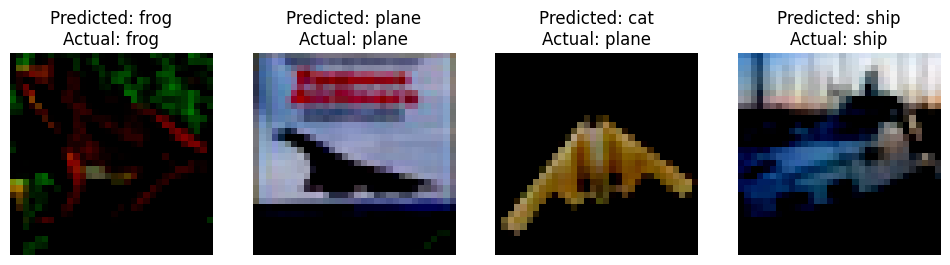

['frog', 'plane', 'cat', 'ship']

In [23]:
# Define a function to display random images and their predictions
def show_random_images_with_predictions(images, predictions, labels, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    random_indices = random.sample(range(len(images)), num_images)
    prediction_labels = []

    for i in range(num_images):
        idx = random_indices[i]
        prediction_labels += [classes[predictions[idx]]]
        axes[i].imshow(images[idx].permute(1, 2, 0))  # Permute the dimensions for display (from [C, H, W] to [H, W, C])
        axes[i].set_title(f"Predicted: {classes[predictions[idx]]}\nActual: {classes[labels[idx]]}")
        axes[i].axis('off')

    plt.show()
    return prediction_labels

# Load a batch of test data
data_iter = iter(testloader)
images, labels = next(data_iter)

# Make predictions using the model
if torch.cuda.is_available():
    images = images.cuda()

outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Convert images, labels, and predictions to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Show random images with predictions
show_random_images_with_predictions(images, predicted, labels, num_images=4)


#Using our model with the higher accuracy (67.5 vs 54%), connect to spotify

In [15]:
!pip install config
!pip install spotipy
!pip install sentence_transformers
!pip install transformers==4.20.1
#!pip install --force-reinstall transformers==4.20.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.0 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=aa593330a422fc906d3eb7e65c2897a6980df63817cf59580054d747561abeef
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 98.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing inst

In [1]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
CLIENT_ID = "0c9a7b2360dd47b7993bb1a11dee4cc4"
CLIENT_SECRET = "e739271fa02e4923be7b7414554619ae"
REDIRECT_URI = "https://example.com/callback/"

default_genres = ['pop', 'rock', 'folk', 'hip-hop', 'electronic']

AUDIO_FEATURES_TO_EXTRACT = ['danceability', 'energy', 'key', 'mode', 'loudness', 'speechiness', 'acousticness',
                             'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

In [3]:
import config as cfg
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import logging
import pickle
import numpy as np


def authorize():
    """
    Create and return a Spotipy instance
    """
    # Define the permissions scope of current user
    scope = "user-read-playback-state,user-modify-playback-state,playlist-modify-public"
    sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=CLIENT_ID,
                                                   client_secret=CLIENT_SECRET,
                                                   redirect_uri=REDIRECT_URI,
                                                   scope=scope, open_browser=False))
    return sp

#this function needs you to download the crossencode_genrepicker.pkl from github into drive. my path is hard coded, but you can change it.
def predict_genre(args):
    """
    Takes given text and returns the most similar genres over a given similarity threshold (limit 5).
    """
    with open('/content/drive/MyDrive/CrossEncoder_GenrePicker.pkl', 'rb') as ce_file:
        similarity_model = pickle.load(ce_file)

    # We want to compute the similarity between the query sentence
    input_text = args['text']

    # Take all combinations of the text and genre
    genres = ["acoustic", "alt-rock", "alternative", "ambient", "anime",
          "bluegrass", "blues", "children", "chill", "classical", "club",
          "comedy", "country", "dance", "disco", "disney", "dubstep", "edm",
          "electronic", "emo", "folk", "funk", "garage", "gospel", "goth",
          "grunge", "guitar", "happy", "hard-rock", "hardcore", "heavy-metal",
          "hip-hop", "holidays", "house", "idm", "indie", "indie-pop", "jazz", "k-pop", "kids", "latin", "metal",
          "movies", "opera", "party", "piano", "pop", "power-pop", "punk", "punk-rock", "r-n-b", "rainy-day", "reggae",
          "reggaeton", "road-trip", "rock", "rock-n-roll", "romance", "sad", "salsa", "show-tunes",
          "singer-songwriter", "ska", "sleep", "songwriter", "soul", "soundtracks", "study", "summer",
          "synth-pop", "tango", "techno", "work-out", "world-music"]
    sentence_combinations = [[input_text, genre] for genre in genres]

    # find the similarity scores between the text and each genre, and sort from highest to lowest
    similarity_scores = similarity_model.predict(sentence_combinations)
    sim_scores_sorted = reversed(np.argsort(similarity_scores))

    # Return the top genres over a given threshold
    top_genres = []
    top_scores = []
    for idx in sim_scores_sorted:
        if args.get('verbose', 0) > 2:
            print("{:.2f}\t{}".format(similarity_scores[idx], genres[idx]))
        if len(top_genres) < 5:
            top_genres.append(genres[idx])
            top_scores.append(similarity_scores[idx])

    for i in range(len(top_scores) - 1):
        if abs(top_scores[i + 1]) - abs(top_scores[i]) > 2:
            top_genres = top_genres[:i + 1]
            break

    # take only the top 5 genres
    if args.get('verbose', 0) > 0:
        print(f"Genres to be passed to Spotify: {top_genres}")
    return top_genres
    # return default_genres


def recommend(param_dict, genre_list, sp, args):
    """
    Takes a dictionary of values for various audio parameters and returns a list of Spotify-recommended track URIs.
    """
    # Send a request to Spotify API using Spotipy
    result = sp.recommendations(seed_genres=genre_list, limit=args['length'], **param_dict)

    # Iterate over response from Spotify, taking track URIs from recommended tracks
    if result:
        track_uris = []
        if args.get('verbose', 0) > 0:
            print('Playlist')
        for track in result['tracks']:
            if args.get('verbose', 0) > 0:
                print(f"Song: {track['name']}, Artist: {dict(track['album']['artists'][0])['name']}\n")
            track_uris.append(track['uri'])
    else:
        logging.warning(f"Nothing was returned from Spotify for url {param_dict}.")
        raise Exception("Nothing returned from Spotify.")
    return track_uris


def create_spotify_playlist(track_uris, input_text, sp, args):
    """
    Utilize Spotipy library to create a playlist given list of track URIs for current user
    """
    print(args.get('verbose', 0))
    # Define username and playlist name to generate
    user_id = sp.me()['id']
    playlist_to_add = f"{input_text} - Data Mining Final Project Test"

    # Create playlist from given track URIs
    sp.user_playlist_create(user_id, playlist_to_add)
    playlists = sp.user_playlists(user_id)
    playlist_uid = playlists['items'][0]['id']
    playlist_link = f"https://open.spotify.com/playlist/{playlist_uid}"
    if args.get('verbose', 0) > 1:
        print(f"Track URIs: {track_uris}")

    # Add tracks
    sp.playlist_add_items(playlist_uid, track_uris)
    logging.info(f"Spotify playlist '{playlist_to_add}' was created for Spotify user '{user_id}'.")

    if args.get('verbose', 0) > 1:
        print(f"User ID: {user_id}")
        print(f"Playlist name: {playlist_to_add}")
    if args.get('verbose', 0) > 0:
        print(playlist_link)
    return playlist_link

In [4]:
import argparse


def parse_args(args_string_list):
    """
    Parses input arguments.
    Returns a structure with all the input arguments
    """
    # Interface definition
    parser = argparse.ArgumentParser(description="Input your mood to generate spotify playlist.",
                                     formatter_class=argparse.RawTextHelpFormatter)

    subparser = parser.add_subparsers(dest='command')

    login = subparser.add_parser('login', help=f'Update client information. "login -h" for more information')
    login.add_argument('--id', type=str, required=False)
    login.add_argument('--secret', type=str, required=False)

    update = subparser.add_parser('input', help=f'Input to pass to model. "input -h" for more information')
    update.add_argument('-t', '--text', type=str, help='Input text')
    update.add_argument('-p', '--popularity', type=int, required=False, help=f'Desired popularity')
    update.add_argument('-l', '--length', type=int, required=False, help=f'Desired length of playlist', default=100)
    update.add_argument('-v', '--verbose', type=int, required=False,
                        help=f'Increase verbosity to show more information during playlist generation', default=0)

    return parser.parse_args(args_string_list)



In [5]:
import pandas as pd
import sys
import os
from config import *
import logging


def raise_spotify_error():
    """
    Raise exception if no result is found from Spotify search.
    """
    raise Exception(f'Nothing Returned from Spotify. Try using different input.')


def generate_params(args, num_playlists=10):
    """
    Generate parameters from given text.
    1. Search Spotify playlists for given text and return number of playlists given in num_playlists
    2. Return all tracks for each playlist, removing tracks that are of NoneType
    3. Find each audio feature for each song -
        then average for each audio feature across entire playlist for each playlist
    4. Average the averages for each playlist, return a dictionary of average for each audio feature
    """
    # Save text argument and initialize a Spotipy instance
    # input_text = args
    input_text = args['text']
    sp = authorize()

    # (1) Get all playlist uris from playlists in search results
    playlists_results = sp.search(q=input_text, limit=num_playlists, type='playlist')['playlists']
    playlist_uris = [playlist['id'] for playlist in playlists_results['items']]
    if args.get('verbose', 0) > 1:
        print("Playlist URIs (list of strings):", playlist_uris, '\n')

    # (2) Get all track uris from playlists in search results
    track_results = [sp.playlist_items(p_uri, limit=100) for p_uri in playlist_uris]
    if len(track_results) == 0:
        raise_spotify_error()

    # Make sure to remove NoneTypes
    track_uris_dict = {playlist_uris[i]: [track['track']['id'] if track['track'] is not None else None for track in
                                          track_results[i]['items']] for i in range(len(playlist_uris))}
    track_uris_dict = {key: [track_uri for track_uri in track_uris_dict[key] if track_uri] for key in track_uris_dict}
    if args.get('verbose', 0) > 4:
        print("Track URIs (dict):\n", track_uris_dict)

    # (3) Get audio features of each track in each playlist
    audio_features = [sp.audio_features(tracks=track_uris_dict[playlist]) for playlist in track_uris_dict]

    # (4) Average playlist averages to get average audio features for individual search
    audio_features = [[track_features for track_features in playlist if track_features] for playlist in audio_features]
    if args.get('verbose', 0) > 4:
        print("Audio Features (list of ):\n", audio_features)

    # Build dictionary of averages
    audio_features = [[{f: track[f] for f in AUDIO_FEATURES_TO_EXTRACT} for track in playlist] for playlist in
                      audio_features]
    avg_audio_features = dict(pd.concat([pd.DataFrame(audio_features[i]).mean() for i in range(len(playlist_uris))],
                                        axis=1).mean(axis=1))

    # Add popularity given to parameter dictionary
    avg_audio_features['popularity'] = args['popularity']
    if args.get('verbose', 0) > 1 :
        print("Features averaged (series):\n", avg_audio_features, '\n')
    return avg_audio_features

In [6]:
def main():
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    args = {
    'text': "apple",  # Replace with the desired text input
    'popularity': 80,  # Replace with the desired popularity value
    'length': 50,  # Replace with the desired playlist length
    'verbose': 2,  # Replace with the desired verbosity level
}

    # Rest of the code remains unchanged
    try:
        sp = authorize()
        genre_text = predict_genre(args)
        if args.get('verbose', 0) > 1:
            print("\nGenres:", genre_text, '\n')
        params = generate_params(args, num_playlists=7)
        tracks = recommend(params, genre_text, sp, args)
        if args.get('verbose', 0) > 1:
            print("Playlist (Song URIs):", tracks)
        # print(args.get('verbose', 0))
        create_spotify_playlist(tracks, args['text'], sp, args)
    except ValueError as e:
        print('ValueError:', e)
        logging.critical(e)
    except AttributeError as e:
        print('AttributeError:', e)
        logging.critical(e)
    except TypeError as e:
        print('TypeError:', e)
        logging.critical(e)
    except Exception as e:
        logging.critical(e)
    return


if __name__ == '__main__':
    main()

Genres to be passed to Spotify: ['r-n-b', 'edm', 'idm', 'happy', 'alternative']

Genres: ['r-n-b', 'edm', 'idm', 'happy', 'alternative'] 

Go to the following URL: https://accounts.spotify.com/authorize?client_id=0c9a7b2360dd47b7993bb1a11dee4cc4&response_type=code&redirect_uri=https%3A%2F%2Fexample.com%2Fcallback%2F&scope=playlist-modify-public+user-modify-playback-state+user-read-playback-state
Enter the URL you were redirected to: https://example.com/callback/?code=AQAjAVpGJah_vk7V7k3Vub0VRwFHH9p5qv22ECI1TOp-eCbFo9hWq-mBfcortEe6iAtmznPI9CBOuylkVVyK_SwCqPlrfhp1_MeRoTsai6ouWjgmzdfEMkgSJV7bQrL-Zuv6cmBd4U_BYg-5uMm-DeuImbf2C_HatXX-gRHwJmd_ZirRPvfEYnqxD_0ZZ_x-NQSIECyAM_lmf7sUMVb9iUFMFL0jSe1ZNnHLHACab75Y2gDBIKO2lfZMJplFBbriXaP86dIsbXnvSP_H2S8Y
Playlist URIs (list of strings): ['3mbFWxQz8zYFV0YzdBHQ9L', '4SKGcvQSltUBoUgzjgmGJT', '0eE7tpkt3nGicMPivFUI8l', '6oFDUjRsuPnlDXC87x9w5N', '1NhpHdAbItQvTRCQPnlXcX', '1DTJE2WoR3OnJdqEYzntSW', '0TaA1sPa9hc0SMAhHGwm0o'] 

Features averaged (series):
 {'da

#Connecting Everything

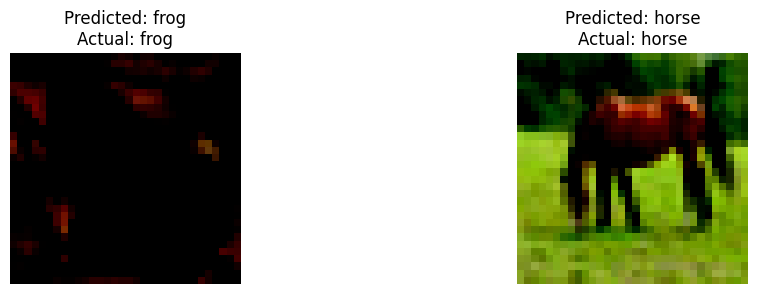

['frog', 'horse']

In [25]:
# Load a batch of test data
data_iter = iter(testloader)
images, labels = next(data_iter)

# Make predictions using the model
if torch.cuda.is_available():
    images = images.cuda()

outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Convert images, labels, and predictions to CPU for visualization
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()

# Show random images with predictions
result = show_random_images_with_predictions(images, predicted, labels, num_images=2)
result

In [26]:
def main():
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    args = {
    'text': result[0],  # Replace with the desired text input - this is where we will call to our image model
    'popularity': 80,  # Replace with the desired popularity value
    'length': 50,  # Replace with the desired playlist length
    'verbose': 2,  # Replace with the desired verbosity level
}

    # Rest of the code remains unchanged
    try:
        sp = authorize()
        genre_text = predict_genre(args)
        if args.get('verbose', 0) > 1:
            print("\nGenres:", genre_text, '\n')
        params = generate_params(args, num_playlists=7)
        tracks = recommend(params, genre_text, sp, args)
        if args.get('verbose', 0) > 1:
            print("Playlist (Song URIs):", tracks)
        # print(args.get('verbose', 0))
        create_spotify_playlist(tracks, args['text'], sp, args)
    except ValueError as e:
        print('ValueError:', e)
        logging.critical(e)
    except AttributeError as e:
        print('AttributeError:', e)
        logging.critical(e)
    except TypeError as e:
        print('TypeError:', e)
        logging.critical(e)
    except Exception as e:
        logging.critical(e)
    return


if __name__ == '__main__':
    main()

Genres to be passed to Spotify: ['r-n-b', 'grunge', 'edm', 'idm', 'songwriter']

Genres: ['r-n-b', 'grunge', 'edm', 'idm', 'songwriter'] 

Playlist URIs (list of strings): ['5duQlUn24JMuOaJ1EDG6pE', '0Ozvfj9DmnrM4il11Qqi18', '1O11sPkBfTji4SxAFxaRUv', '3DvD1rYYPZIBg6PmIzltMV', '0koA9jQKXcWEJkIuCWjzCt', '4JlER9CKk7i1FpHwNqt5dS', '1r3LI9IlDVdlInlmgPILRO'] 

Features averaged (series):
 {'danceability': 0.5654378414699214, 'energy': 0.4501765552654396, 'key': 5.185418167266907, 'mode': 0.7656642657062825, 'loudness': -13.573103797519007, 'speechiness': 0.08854393050553555, 'acousticness': 0.5453934477989862, 'instrumentalness': 0.2236308746993064, 'liveness': 0.2019019511137789, 'valence': 0.43346073516073097, 'tempo': 117.04792506469254, 'time_signature': 3.78999599839936, 'popularity': 80} 

Playlist
Song: Cow Cud Is A Twin, Artist: Aphex Twin

Song: I'm Home, Artist: Various Artists

Song: Cry Osaka Cry, Artist: Arovane

Song: Like a Stone, Artist: Audioslave

Song: Simple Machine, Arti

#Future Steps:
- generalize CNN model to not just 10 classes of images (airplane, automobile, bird, cat, deer, dog, frog, horse, truck)
- Our spotify algorithm works for longer strings of text too - right now our input is just one word from the model; can we use sentiment analysis to create a longer string of text / phrase to input?
- publicize spotify project so other spotify users can also use it